In [48]:
import torch
import gpytorch
import botorch
from gpytorch.constraints.constraints import Interval

class ExactGPSEModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    """An exact Gaussian process (GP) model with a squared exponential (SE) kernel.

    ExactGP: The base class of gpytorch for any Gaussian process latent function to be
        used in conjunction with exact inference.
    GPyTorchModel: The easiest way to use a GPyTorch model in BoTorch.
        This adds all the api calls that botorch expects in its various modules.

    Attributes:
        train_x: (N x D) The training features X.
        train_y: (N x 1) The training targets y.
        lengthscale_constraint: Constraint for lengthscale of SE-kernel, gpytorch.constraints.
        lengthscale_hyperprior: Hyperprior for lengthscale of SE-kernel, gpytorch.priors.
        outputscale_constraint: Constraint for outputscale of SE-kernel, gpytorch.constraints.
        outputscale_hyperprior: Hyperprior for outputscale of SE-kernel, gpytorch.priors.
        noise_constraint: Constraint for noise, gpytorch.constraints.
        noise_hyperprior: Hyperprior for noise, gpytorch.priors.
        ard_num_dims: Set this if you want a separate lengthscale for each input dimension.
            Should be D if train_x is a N x D matrix.
        prior_mean: Value for constant mean.
    """

    _num_outputs = 1  # To inform GPyTorchModel API.

    def __init__(
        self,
        train_x: torch.Tensor,
        train_y: torch.Tensor,
        lengthscale_constraint=None,
        lengthscale_hyperprior=None,
        outputscale_constraint=None,
        outputscale_hyperprior=None,
        noise_constraint=  Interval(10**(-6),2*10**(-6)), #None, Interval(10**(-6),1.1*10**(-6)),
        noise_hyperprior=None,
        ard_num_dims=None,
        prior_mean=0,
    ):
        """Inits GP model with data and a Gaussian likelihood."""
        likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_constraint=noise_constraint, noise_prior=noise_hyperprior
        )
        if train_y is not None:
            train_y = train_y.squeeze(-1)
        super(ExactGPSEModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ZeroMean()  #gpytorch.means.ConstantMean()
        if prior_mean != 0:
            self.mean_module.initialize(constant=prior_mean)
            self.mean_module.constant.requires_grad = False

        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                ard_num_dims=ard_num_dims,
                lengthscale_prior=lengthscale_hyperprior,
                lengthscale_constraint=lengthscale_constraint,
            ),
            outputscale_prior=outputscale_hyperprior,
            outputscale_constraint=outputscale_constraint,
        )
        # Initialize lengthscale and outputscale to mean of priors.
        if lengthscale_hyperprior is not None:
            self.covar_module.base_kernel.lengthscale = lengthscale_hyperprior.mean
        if outputscale_hyperprior is not None:
            self.covar_module.outputscale = outputscale_hyperprior.mean

    def forward(self, x):
        """Compute the prior latent distribution on a given input.

        Typically, this will involve a mean and kernel function. The result must be a
        MultivariateNormal. Calling this model will return the posterior of the latent
        Gaussian process when conditioned on the training data. The output will be a
        MultivariateNormal.

        Args:
            x: (n x D) The test points.

        Returns:
            A MultivariateNormal.
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    



class DerivativeExactGPSEModel(ExactGPSEModel):
    """Derivative of the ExactGPSEModel w.r.t. the test points x.

    Since differentiation is a linear operator this is again a Gaussian process.

    Attributes:
        D: Dimension of train_x-/input-data.
        normalize: Optional normalization function for policy parameterization.
        unnormalize: Optional unnormalization function for policy
            parameterization.
        N_max: Maximum number of training samples (train_x, N) for model inference.
        lengthscale_constraint: Constraint for lengthscale of SE-kernel, gpytorch.constraints.
        lengthscale_hyperprior: Hyperprior for lengthscale of SE-kernel, gpytorch.priors.
        outputscale_constraint: Constraint for outputscale of SE-kernel, gpytorch.constraints.
        outputscale_hyperprior: Hyperprior for outputscale of SE-kernel, gpytorch.priors.
        noise_constraint: Constraint for noise, gpytorch.constraints.
        noise_hyperprior: Hyperprior for noise, gpytorch.priors.
        ard_num_dims: Set this if you want a separate lengthscale for each input dimension.
            Should be D if train_x is a N x D matrix.
        prior_mean: Value for constant mean.
    """

    def __init__(
        self,
        D: int,
        train_x: torch.Tensor,
        train_y: torch.Tensor,
        normalize=None,
        unnormalize=None,
        N_max=None,
        lengthscale_constraint=None,
        lengthscale_hyperprior=None,
        outputscale_constraint=None,
        outputscale_hyperprior=None,
        noise_constraint= Interval(10**(-6),2*10**(-6)), #None,  Interval(10**(-6),1.1*10**(-6)),
        noise_hyperprior=None,
        ard_num_dims=None,
        prior_mean=0.0,
    ):
        """Inits GP model with data and a Gaussian likelihood."""
        # train_x_init, train_y_init = (
        #     torch.empty(0, D),
        #     torch.empty(0),
        # )
        super(DerivativeExactGPSEModel, self).__init__(
            train_x,
            train_y,
            lengthscale_constraint,
            lengthscale_hyperprior,
            outputscale_constraint,
            outputscale_hyperprior,
            noise_constraint,
            noise_hyperprior,
            ard_num_dims,
            prior_mean,
        )

        self.N_max = N_max
        self.D = D
        self.N = self.train_inputs[0].shape[0] #    self.N = train_x.shape[0]
        
        # self.train_xs = train_x_init
        # self.train_ys = train_y_init
        if normalize is None:
            normalize = lambda params: params
        self.normalize = normalize
        if unnormalize is None:
            unnormalize = lambda params: params
        self.unnormalize = unnormalize




    def get_KXX_inv(self,index=0):
        """Get the inverse matrix of K(X,X).

        Returns:
            The inverse of K(X,X).
        """
        L_inv_upper = self.prediction_strategy.covar_cache.detach()
        L_inv_upper = L_inv_upper.reshape(-1,self.N,self.N)
        L_inv_upper = L_inv_upper[index]
        
        return torch.mm(L_inv_upper,L_inv_upper.transpose(0, 1))  #L_inv_upper @ L_inv_upper.transpose(0, 1)



    def _get_KxX_dx(self, x,index=0):
        """Computes the analytic derivative of the kernel K(x,X) w.r.t. x.

        Args:
            x: (n x D) Test points.

        Returns:
            (n x D) The derivative of K(x,X) w.r.t. x. so the shape is n x D x trainX_num
        """
        X = self.train_inputs[0]
        X = X.reshape(-1,self.N,self.D)
        X = X[index]
        
        n = x.shape[0]
        K_xX = self.covar_module(x, X).evaluate()
        lengthscale = self.covar_module.base_kernel.lengthscale.detach()
        
        part1 =  -torch.eye(self.D, device=x.device)/ lengthscale ** 2 # shape D x D
        part2 = ((x.view(n, 1, self.D) - X.view(1, self.N, self.D))* K_xX.view(n, self.N, 1)).transpose(1, 2) #shape predictX_num x D x trainX_num
              # shape predictX_num x trainX_num x D                shape predictX_num x trainX_num x D
        res = part1 @ part2
        
        return res 
        # return (
        #     -torch.eye(self.D, device=x.device)
        #     / lengthscale ** 2
        #     @ (
        #         (x.view(n, 1, self.D) - X.view(1, self.N, self.D))
        #         * K_xX.view(n, self.N, 1)
        #     ).transpose(1, 2)
        # )

    def _get_Kxx_dx2(self):
        """Computes the analytic second derivative of the kernel K(x,x) w.r.t. x.

        Args:
            x: (n x D) Test points.

        Returns:
            (n x D x D) The second derivative of K(x,x) w.r.t. x.
        """
        lengthscale = self.covar_module.base_kernel.lengthscale.detach()
        sigma_f = self.covar_module.outputscale.detach()
        
        res =  torch.eye(self.D, device=lengthscale.device) / lengthscale ** 2 * sigma_f
        
        return res
        # return (
        #     torch.eye(self.D, device=lengthscale.device) / lengthscale ** 2
        # ) * sigma_f

    def posterior_derivative(self, x,index=0):
        """Computes the posterior of the derivative of the GP w.r.t. the given test
        points x.

        Args:
            x: (n x D) Test points.

        Returns:
            A GPyTorchPosterior.
        """
        
        train_targets = self.train_targets.reshape(-1,self.N)
        
        if self.prediction_strategy is None:
            self.posterior(x)  # Call this to update prediction strategy of GPyTorch.
        K_xX_dx = self._get_KxX_dx(x,index)
        mean_d = K_xX_dx @ self.get_KXX_inv(index) @ train_targets[index]
        variance_d = (
            self._get_Kxx_dx2() - K_xX_dx @ self.get_KXX_inv(index) @ K_xX_dx.transpose(1, 2)
        )
        variance_d = variance_d.clamp_min(1e-9)

        return mean_d, variance_d



In [49]:
import torch
import numpy as np
#from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP,FixedNoiseGP
from botorch.test_functions import Ackley,Beale,Branin,Rosenbrock,SixHumpCamel,Hartmann,Powell,DixonPrice,Levy,StyblinskiTang,Griewank
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement,PosteriorMean,qKnowledgeGradient
from botorch.optim import optimize_acqf
from botorch.utils.transforms import unnormalize,normalize
from torch.quasirandom import SobolEngine
from gpytorch.kernels import MaternKernel, RBFKernel, IndexKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.means import ZeroMean
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

Text(0.5, 1.0, 'GP')

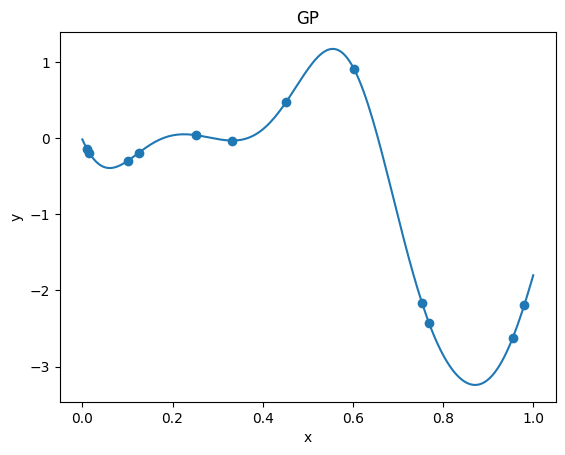

In [50]:
import GPy
import numpy as np

kernel = GPy.kern.RBF(input_dim=1,variance=3,lengthscale=0.15)
m = GPy.models.GPRegression(np.array([0.]).reshape(-1,1),np.array([0.]).reshape(-1,1),kernel)
m.Gaussian_noise.variance.fix(0.1**2)

X_total = np.linspace(0,1,200).reshape(-1,1)

np.random.seed(1234)
Y_total = m.posterior_samples_f(X_total,size=1).reshape(-1,1)

delta = X_total[1]-X_total[0]
grad = (Y_total[1:] - Y_total[:-1])/delta

X_train = X_total[[2,3,20,25,50,66,90,120,150,153,190,195]]
Y_train = Y_total[[2,3,20,25,50,66,90,120,150,153,190,195]]

plt.scatter(X_train,Y_train)
plt.plot(X_total,Y_total)

plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')

In [51]:
dim = 1
model = DerivativeExactGPSEModel(D=1,train_x=torch.tensor(X_train).reshape(-1,1), 
                                 train_y=torch.tensor(Y_train).reshape(-1,1),prior_mean=0).to(device)

mll = ExactMarginalLogLikelihood(model.likelihood, model) .to(device)

fit_gpytorch_mll(mll)

print(model.covar_module.base_kernel.lengthscale)
print(model.covar_module.outputscale )

tensor([[0.1408]], grad_fn=<SoftplusBackward0>)
tensor(2.9603, grad_fn=<SoftplusBackward0>)


Text(0.5, 1.0, 'GP')

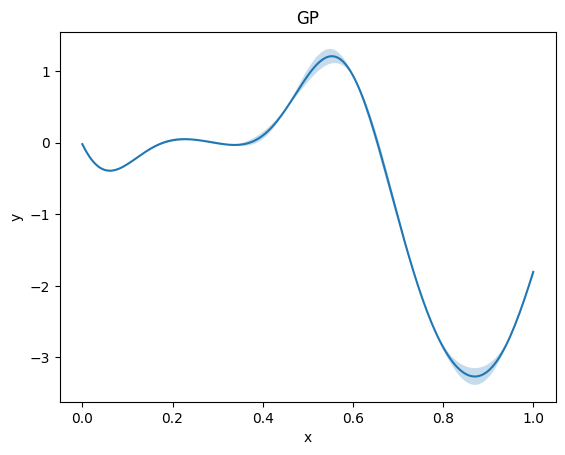

In [52]:
prediction1 = model(torch.tensor(X_total).reshape(-1,1))
pre_mean1 = prediction1.mean.detach().numpy().reshape(-1,)
pre_std1 = np.sqrt(prediction1.variance.detach().numpy()).reshape(-1,)

plt.plot(X_total,pre_mean1 )
plt.fill_between(X_total.reshape(-1,), pre_mean1-2*pre_std1, pre_mean1+2*pre_std1,alpha=0.25)

plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')

Text(0.5, 1.0, 'GP')

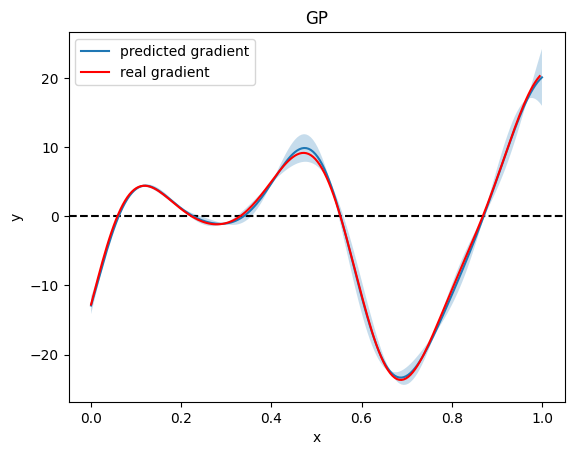

In [102]:
torch.set_default_dtype(dtype)
mean_d, variance_d = model.posterior_derivative(torch.tensor(X_total).reshape(-1,1),index=0)

pre_mean1 = mean_d.detach().numpy().reshape(-1,)
pre_std1 = np.sqrt(variance_d.detach().numpy()).reshape(-1,)

plt.axhline(y=0., color='black', linestyle='--')
plt.plot(X_total,pre_mean1,label='predicted gradient' )
plt.fill_between(X_total.reshape(-1,), pre_mean1-2*pre_std1, pre_mean1+2*pre_std1,alpha=0.25)
plt.plot(X_total[:-1],grad,label='real gradient',color='red')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')

Text(0.5, 1.0, 'GP')

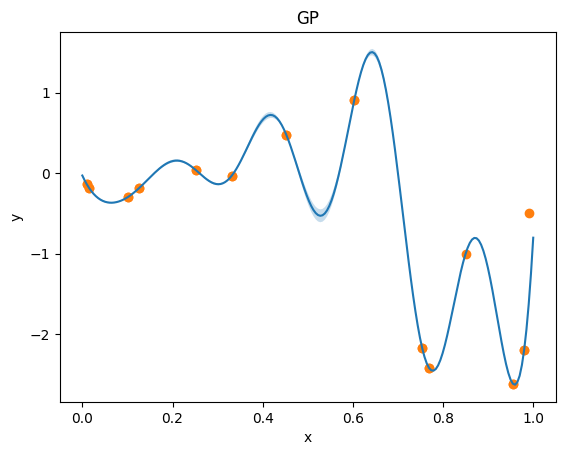

In [74]:
dim = 1
model_temp = model.get_fantasy_model(torch.tensor([[0.85],[0.99]]).reshape(2,-1,dim), torch.tensor([[-1.],[-0.5]]).reshape(2,1))
model_temp.N = model_temp.N + 1

prediction1 = model_temp(torch.tensor(X_total).reshape(-1,1))
pre_mean1 = prediction1.mean[0].detach().numpy().reshape(-1,)
pre_std1 = np.sqrt(prediction1.variance[0].detach().numpy()).reshape(-1,)

plt.plot(X_total,pre_mean1 )
plt.fill_between(X_total.reshape(-1,), pre_mean1-2*pre_std1, pre_mean1+2*pre_std1,alpha=0.25)
plt.scatter(model_temp.train_inputs[0],model_temp.train_targets)

plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')

In [ ]:
        X = self.train_inputs[0]
        X = X.reshape(-1,self.N,self.D)
        X = X[index]
        
        n = x.shape[0]
        K_xX = self.covar_module(x, X).evaluate()
        lengthscale = self.covar_module.base_kernel.lengthscale.detach()
        
        part1 =  -torch.eye(self.D, device=x.device)/ lengthscale ** 2
        part2 = ((x.view(n, 1, self.D) - X.view(1, self.N, self.D))* K_xX.view(n, self.N, 1)).transpose(1, 2)
        

In [86]:
x = torch.tensor(X_total).reshape(-1,1)
X = model_temp.train_inputs[0]
lengthscale = model_temp.covar_module.base_kernel.lengthscale.detach()
n = x.shape[0]
K_xX = model_temp.covar_module(x,X).evaluate()

In [76]:
X.shape # shape fansty_num x trainX_num x dimension 

torch.Size([2, 13, 1])

In [77]:
model_temp.covar_module(x,X).evaluate().shape # shape fansty_num x predictX_num x trainX_num

torch.Size([2, 200, 13])

In [78]:
model_temp.covar_module.base_kernel.lengthscale.detach().shape #1 x 1

torch.Size([1, 1])

In [79]:
-torch.eye(model_temp.D, device=x.device)/ lengthscale ** 2 #shape is D x D

tensor([[-50.4521]])

In [80]:
((x.view(n, 1, model_temp.D) - X.view(1, model_temp.N, model_temp.D))* K_xX.view(n, model_temp.N, 1)).transpose(1, 2)

RuntimeError: shape '[1, 13, 1]' is invalid for input of size 26

In [100]:
res1 = (x.unsqueeze(0).repeat(2, 1, 1).view(2,n, 1, model_temp.D) - X.view(2,1, model_temp.N, model_temp.D)) * K_xX.view(2,n, model_temp.N, 1).transpose(-2, -1)

In [101]:
res1.shape

torch.Size([2, 200, 13, 13])

In [94]:
X.view(2,1, model_temp.N, model_temp.D)

tensor([[[[0.0101],
          [0.0151],
          [0.1005],
          [0.1256],
          [0.2513],
          [0.3317],
          [0.4523],
          [0.6030],
          [0.7538],
          [0.7688],
          [0.9548],
          [0.9799],
          [0.8500]]],


        [[[0.0101],
          [0.0151],
          [0.1005],
          [0.1256],
          [0.2513],
          [0.3317],
          [0.4523],
          [0.6030],
          [0.7538],
          [0.7688],
          [0.9548],
          [0.9799],
          [0.9900]]]])

In [90]:
K_xX.view(2,n, model_temp.N, 1).transpose(-2, -1)

tensor([[[[2.9527e+00, 2.9433e+00, 2.2944e+00,  ..., 3.0503e-10,
           8.9494e-11, 3.5971e-08]],

         [[2.9584e+00, 2.9527e+00, 2.3521e+00,  ..., 3.8832e-10,
           1.1466e-10, 4.4593e-08]],

         [[2.9603e+00, 2.9584e+00, 2.4082e+00,  ..., 4.9373e-10,
           1.4671e-10, 5.5211e-08]],

         ...,

         [[8.9494e-11, 1.1466e-10, 6.3713e-09,  ..., 2.8693e+00,
           2.9527e+00, 1.8062e+00]],

         [[6.9763e-11, 8.9494e-11, 5.0818e-09,  ..., 2.8420e+00,
           2.9433e+00, 1.7421e+00]],

         [[5.4313e-11, 6.9763e-11, 4.0481e-09,  ..., 2.8114e+00,
           2.9302e+00, 1.6781e+00]]],


        [[[2.9527e+00, 2.9433e+00, 2.2944e+00,  ..., 3.0503e-10,
           8.9494e-11, 5.4176e-11]],

         [[2.9584e+00, 2.9527e+00, 2.3521e+00,  ..., 3.8832e-10,
           1.1466e-10, 6.9589e-11]],

         [[2.9603e+00, 2.9584e+00, 2.4082e+00,  ..., 4.9373e-10,
           1.4671e-10, 8.9272e-11]],

         ...,

         [[8.9494e-11, 1.1466e-10, 6.3713

In [83]:
x.view(n, 1, model_temp.D).shape

torch.Size([200, 1, 1])

Text(0.5, 1.0, 'GP')

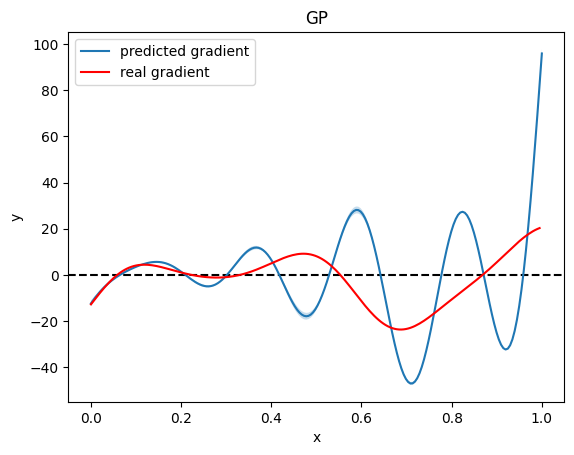

In [11]:
torch.set_default_dtype(dtype)
model_temp.N = model.N+1
mean_d, variance_d = model_temp.posterior_derivative(torch.tensor(X_total).reshape(-1,1),index=0)

# model_temp.train_targets = model_temp.train_targets.reshape(model_temp.N)

pre_mean1 = mean_d.detach().numpy().reshape(-1,)
pre_std1 = np.sqrt(variance_d.detach().numpy()).reshape(-1,)

plt.axhline(y=0., color='black', linestyle='--')
plt.plot(X_total,pre_mean1,label='predicted gradient' )
plt.fill_between(X_total.reshape(-1,), pre_mean1-2*pre_std1, pre_mean1+2*pre_std1,alpha=0.25)
plt.plot(X_total[:-1],grad,label='real gradient',color='red')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')

Text(0.5, 1.0, 'GP')

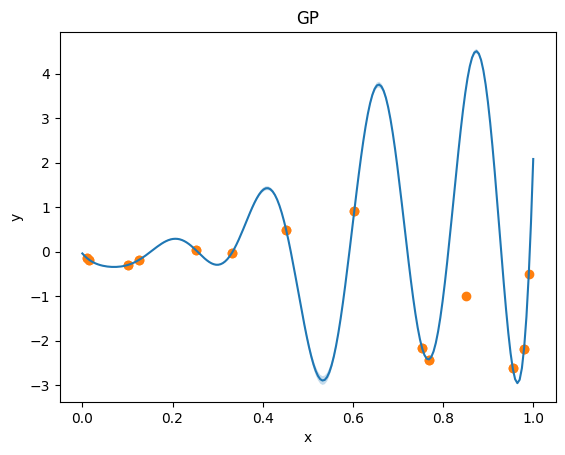

In [78]:
dim = 1
model_temp = model.get_fantasy_model(torch.tensor([[0.85],[0.99]]).reshape(2,-1,dim), torch.tensor([[-1.],[-0.5]]).reshape(2,1))

prediction1 = model_temp(torch.tensor(X_total).reshape(-1,1))
pre_mean1 = prediction1.mean[1].detach().numpy().reshape(-1,)
pre_std1 = np.sqrt(prediction1.variance[1].detach().numpy()).reshape(-1,)

plt.plot(X_total,pre_mean1 )
plt.fill_between(X_total.reshape(-1,), pre_mean1-2*pre_std1, pre_mean1+2*pre_std1,alpha=0.25)
plt.scatter(model_temp.train_inputs[0],model_temp.train_targets)

plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')

Text(0.5, 1.0, 'GP')

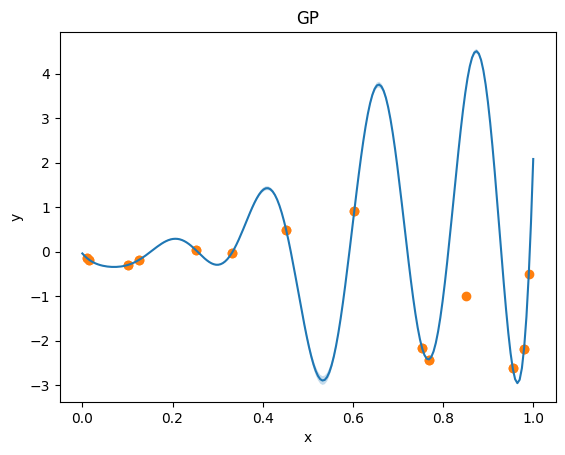

In [15]:
dim = 1
model_temp = model.get_fantasy_model(torch.tensor([[0.85],[0.99]]).reshape(2,-1,dim), torch.tensor([[-1.],[-0.5]]).reshape(2,1))

prediction1 = model_temp(torch.tensor(X_total).reshape(-1,1))
pre_mean1 = prediction1.mean[1].detach().numpy().reshape(-1,)
pre_std1 = np.sqrt(prediction1.variance[1].detach().numpy()).reshape(-1,)

plt.plot(X_total,pre_mean1 )
plt.fill_between(X_total.reshape(-1,), pre_mean1-2*pre_std1, pre_mean1+2*pre_std1,alpha=0.25)
plt.scatter(model_temp.train_inputs[0],model_temp.train_targets)

plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')

Text(0.5, 1.0, 'GP')

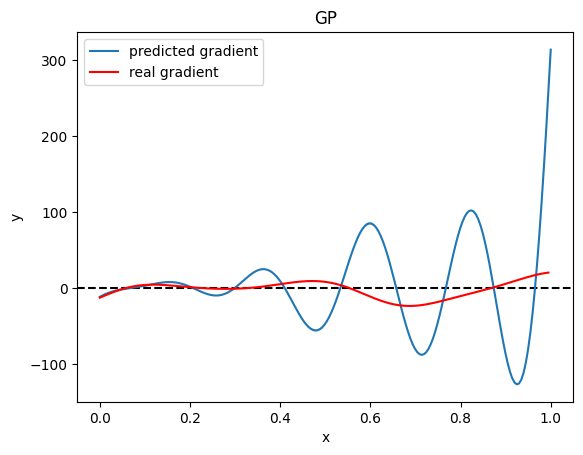

In [13]:
torch.set_default_dtype(dtype)
model_temp.N = model.N+1
mean_d, variance_d = model_temp.posterior_derivative(torch.tensor(X_total).reshape(-1,1),index=1)

# model_temp.train_targets = model_temp.train_targets.reshape(model_temp.N)

pre_mean1 = mean_d.detach().numpy().reshape(-1,)
pre_std1 = np.sqrt(variance_d.detach().numpy()).reshape(-1,)

plt.axhline(y=0., color='black', linestyle='--')
plt.plot(X_total,pre_mean1,label='predicted gradient' )
plt.fill_between(X_total.reshape(-1,), pre_mean1-2*pre_std1, pre_mean1+2*pre_std1,alpha=0.25)
plt.plot(X_total[:-1],grad,label='real gradient',color='red')

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('GP')